<a href="https://colab.research.google.com/github/aSafarpoor/SCLFB/blob/main/SCLFB_phase0_content_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle
import random
import json
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import math
import cv2
from google.colab.patches import cv2_imshow
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tqdm.pandas()

#go to path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/MSc/SCLAD/
%mkdir FB15k237
%cd FB15k237

/content/drive/MyDrive/MSc/SCLAD
mkdir: cannot create directory ‘FB15k237’: File exists
/content/drive/MyDrive/MSc/SCLAD/FB15k237


#read data

In [ ]:
# !wget https://raw.githubusercontent.com/intfloat/SimKGC/main/data/FB15k237/FB15k_mid2name.txt
# !wget https://raw.githubusercontent.com/intfloat/SimKGC/main/data/FB15k237/FB15k_mid2description.txt
# !wget https://raw.githubusercontent.com/intfloat/SimKGC/main/data/FB15k237/test.txt
# !wget https://raw.githubusercontent.com/intfloat/SimKGC/main/data/FB15k237/train.txt
# !wget https://raw.githubusercontent.com/intfloat/SimKGC/main/data/FB15k237/valid.txt

In [ ]:
!ls

FB15k_mid2description.txt  FB15k_mid2name.txt  test.txt  train.txt  valid.txt


In [ ]:
des = []
for line in open('FB15k_mid2description.txt', 'r'):
    des.append(line.replace('\n','').split('\t'))
des = pd.DataFrame(des)
des = des.rename(columns={0: "namecode", 1: "description"})
des.head(5)

,namecode,description
0,/m/06rf7,"""Schleswig-Holstein is the northernmost of the..."
1,/m/0c94fn,"""Gary Roger Rydstrom is an American sound desi..."
2,/m/016ywr,"""Jeremy John Irons is an English actor. After ..."
3,/m/01yjl,"""The Chicago Cubs are a professional baseball ..."
4,/m/02hrh1q,"""An actor is a person portraying a character i..."


In [ ]:
dfname = []
for line in open('FB15k_mid2name.txt', 'r'):
    dfname.append(line.replace('\n','').split('\t'))
dfname = pd.DataFrame(dfname)
dfname = dfname.rename(columns={0: "namecode", 1: "title"})
dfname.head(5)

,namecode,title
0,/m/06rf7,Schleswig-Holstein
1,/m/0c94fn,Gary_Rydstrom
2,/m/016ywr,Jeremy_Irons
3,/m/01yjl,Chicago_Cubs
4,/m/02hrh1q,Actor-GB


In [ ]:
train = []
for line in open('train.txt', 'r'):
    train.append(line.replace('\n','').split('\t'))
train = pd.DataFrame(train)
train = train.rename(columns={0: "namecode1", 1: "title", 2: "namecode2"})
train.head(5)

,namecode1,title,namecode2
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8


In [ ]:
test = []
for line in open('test.txt', 'r'):
    test.append(line.replace('\n','').split('\t'))
test = pd.DataFrame(test)
test = test.rename(columns={0: "namecode1", 1: "title", 2: "namecode2"})
test.head(5)

,namecode1,title,namecode2
0,/m/08966,/travel/travel_destination/climate./travel/tra...,/m/05lf_
1,/m/01hww_,/music/performance_role/regular_performances./...,/m/01q99h
2,/m/09v3jyg,/film/film/release_date_s./film/film_regional_...,/m/0f8l9c
3,/m/02jx1,/location/location/contains,/m/013t85
4,/m/02jx1,/location/location/contains,/m/0m0bj


In [ ]:
valid = []
for line in open('valid.txt', 'r'):
    valid.append(line.replace('\n','').split('\t'))
valid = pd.DataFrame(valid)
valid = valid.rename(columns={0: "namecode1", 1: "title", 2: "namecode2"})
valid.head(5)

,namecode1,title,namecode2
0,/m/07pd_j,/film/film/genre,/m/02l7c8
1,/m/06wxw,/location/location/time_zones,/m/02fqwt
2,/m/01t94_1,/people/person/spouse_s./people/marriage/type_...,/m/04ztj
3,/m/02xcb6n,/award/award_category/winners./award/award_hon...,/m/04x4s2
4,/m/07f_7h,/film/film/release_date_s./film/film_regional_...,/m/04gzd


In [ ]:
def reset_index(df):
    df = df.reset_index()
    del df['index']
    return df

test = reset_index(test)
train = reset_index(train)
valid = reset_index(valid)

In [ ]:
"number of relations is: " + str(len(set(test.title)))

'number of relations is: 224'

#preprocessing

In [ ]:
class Normalizer:
    # based on https://www.geeksforgeeks.org/normalizing-textual-data-with-python/
    def __init__(self):
        # import regex
        self.stop_words = set(stopwords.words('english'))

    def text_normalizer(self,text):
        if type(text) == type([]):
            text = text[0]
        text = str(text)
        # convert to lower case
        lower_string = text.lower()
        # remove numbers
        no_number_string = re.sub(r'\d+','',lower_string)
        # remove all punctuation except words and space
        no_punc_string = re.sub(r'[^\w\s]','', no_number_string)
        # remove white spaces
        no_wspace_string = no_punc_string.strip()
        # convert string to list of words
        lst_string = [no_wspace_string][0].split()
        # remove stopwords
        no_stpwords_string=""
        for i in lst_string:
            if (not i in self.stop_words) and len(i)>1:
                no_stpwords_string += i+' '
        # removing last space
        no_stpwords_string = no_stpwords_string[:-1]
        output = no_stpwords_string
        return output

In [ ]:
normalizer = Normalizer()
des["description"] = des["description"].apply(normalizer.text_normalizer)
des.head(5)

,namecode,description
0,/m/06rf7,schleswigholstein northernmost sixteen states ...
1,/m/0c94fn,gary roger rydstrom american sound designer di...
2,/m/016ywr,jeremy john irons english actor receiving clas...
3,/m/01yjl,chicago cubs professional baseball team locate...
4,/m/02hrh1q,actor person portraying character dramatic com...


In [ ]:
# dez = des.set_index('namecode').join(dfname.set_index('title'))
des = pd.merge(des,dfname,left_on=['namecode'],right_on=['namecode'])

In [ ]:
des['text'] = des.title+" "+des.description

In [ ]:
normalizer = Normalizer()
des["text"] = des["text"].apply(normalizer.text_normalizer)
des.head(5)

,namecode,description,title,text
0,/m/06rf7,schleswigholstein northernmost sixteen states ...,Schleswig-Holstein,schleswigholstein schleswigholstein northernmo...
1,/m/0c94fn,gary roger rydstrom american sound designer di...,Gary_Rydstrom,gary_rydstrom gary roger rydstrom american sou...
2,/m/016ywr,jeremy john irons english actor receiving clas...,Jeremy_Irons,jeremy_irons jeremy john irons english actor r...
3,/m/01yjl,chicago cubs professional baseball team locate...,Chicago_Cubs,chicago_cubs chicago cubs professional basebal...
4,/m/02hrh1q,actor person portraying character dramatic com...,Actor-GB,actorgb actor person portraying character dram...


##embedding

In [ ]:
des.reset_index(drop=True, inplace=True)

In [ ]:
try:
    from sentence_transformers import SentenceTransformer
except:
    ! pip install sentence_transformers
    from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.6 MB/s 
     |████████████████████████████████| 4.4 MB 11.0 MB/s 
     |████████████████████████████████| 1.2 MB 56.2 MB/s 
     |████████████████████████████████| 101 kB 15.1 MB/s 
     |████████████████████████████████| 596 kB 67.8 MB/s 
     |████████████████████████████████| 6.6 MB 55.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=77045eee89c306522e9ab1c375dac266ef214c7f7c338478fea67627a3b2068f
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
def embedding_sentenceBert(sent):
    sent_embedding = sbert_model.encode(sent)
    return sent_embedding

In [ ]:
des['embedded'] = des['text'].progress_apply(embedding_sentenceBert)

100%|██████████| 14904/14904 [03:58<00:00, 62.47it/s]


In [ ]:
des.to_pickle('des.p')

## content based

(14904, 14904)

In [ ]:
et = np.array(des.embedded)

In [ ]:
def dot_product(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.dot(v1,v2)

def cosine_measure(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    prod = np.dot(v1,v2)
    len1 = math.sqrt(np.dot(v1, v1))
    len2 = math.sqrt(np.dot(v2, v2))
    return prod / (len1 * len2)

In [ ]:
# sim = np.zeros((len(et),len(et)))

# for i in tqdm(range(len(et))):
#     for j in range(len(et)):
#         v1 = et[i]
#         v2 = et[j]
#         s = cosine_measure(v1, v2)
#         sim[i][j] = s

with open('sim.pkl','rb') as f:
     sim = pickle.load(f)

100%|██████████| 14904/14904 [35:22<00:00,  7.02it/s]


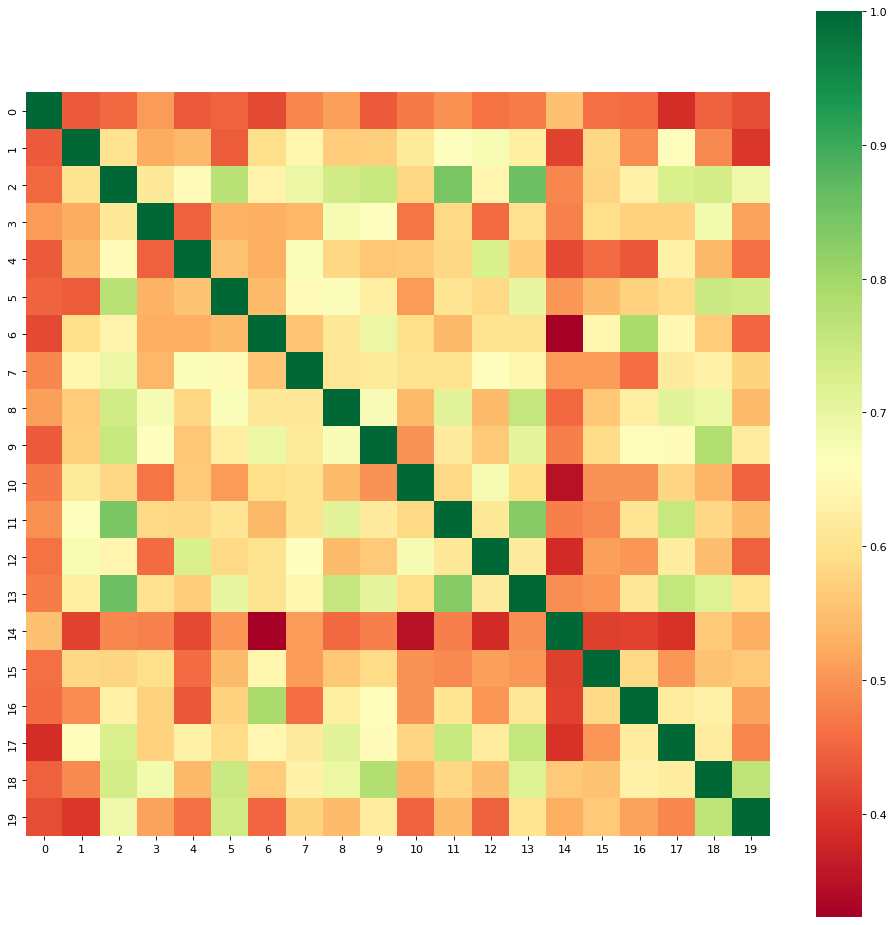

In [ ]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(15, 15), dpi=80)
ax = sns.heatmap(sim[:20,:20],cmap='RdYlGn',square=True)

plt.show()

In [ ]:
des.loc[11].title,des.loc[13].title

('Henry_V', 'Maggie_Gyllenhaal')

In [ ]:
with open('sim.pkl','wb') as f:
         pickle.dump(sim, f)

In [ ]:
nodes = test.namecode1 + test.namecode2
nodes = list(set(nodes))
len(nodes) 

20354

In [ ]:
test

,namecode1,namecode2
0,/m/08966,/m/05lf_
1,/m/01hww_,/m/01q99h
2,/m/09v3jyg,/m/0f8l9c
3,/m/02jx1,/m/013t85
4,/m/02jx1,/m/0m0bj
...,...,...
20461,/m/0l5yl,/m/02hrh1q
20462,/m/01z5tr,/m/09c7w0
20463,/m/0p5mw,/m/06w87
20464,/m/0727h,/m/0bk25


In [ ]:
print(len(test))
try:
    test = test.drop(columns=['title'])
except:
    pass
test = test.drop_duplicates()
print(len(test))
test.head(5)

20466
20354


,namecode1,namecode2
0,/m/08966,/m/05lf_
1,/m/01hww_,/m/01q99h
2,/m/09v3jyg,/m/0f8l9c
3,/m/02jx1,/m/013t85
4,/m/02jx1,/m/0m0bj


In [ ]:
import random
random.randint(0,len(nodes)-1)

16963

In [ ]:
truecounter = 0
f = 0
for i in tqdm(range(len(test))):
    row = test.loc[i]
    h = row[0]
    t = row[1]

    while(True):
        n = random.randint(0,len(des)-1)
        if  len(test[test.namecode1==h][test.namecode2==des.loc[n][0]])==0:
            break
    indexh = des[des.namecode==h].index
    indext = des[des.namecode==t].index

    s1 = sim[indexh,indext]
    s2 = sim[indexh,n]

    if s1>s2:
        truecounter+= 1
    
f = len(test)-truecounter
t = truecounter
print(t,f,int(100*t/(t+f)))

  0%|          | 0/20354 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 20354/20354 [02:10<00:00, 156.32it/s]

12328 8026 60


In [ ]:
print(t,f,int(100*t/(t+f)))

12328 8026 60


In [ ]:
'''output is 60%'''

'output is 60%'